In [28]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import pickle
import time
import numpy as np 
import cv2 
import matplotlib.pyplot as plt
%matplotlib inline
import glob
from collections import deque

In [3]:
car_images = glob.glob('vehicles/vehicles/**/*.png')
noncar_images = glob.glob('non-vehicles/non-vehicles/**/*.png')
print(len(car_images), len(noncar_images))

8792 8968


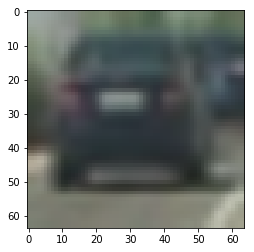

In [34]:
im1 = plt.imread(car_images[0])
plt.imshow(im1)

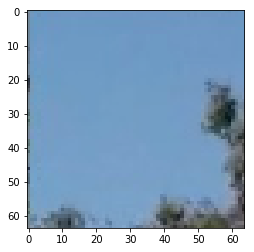

In [35]:
im2 = plt.imread(noncar_images[0])
plt.imshow(im2)

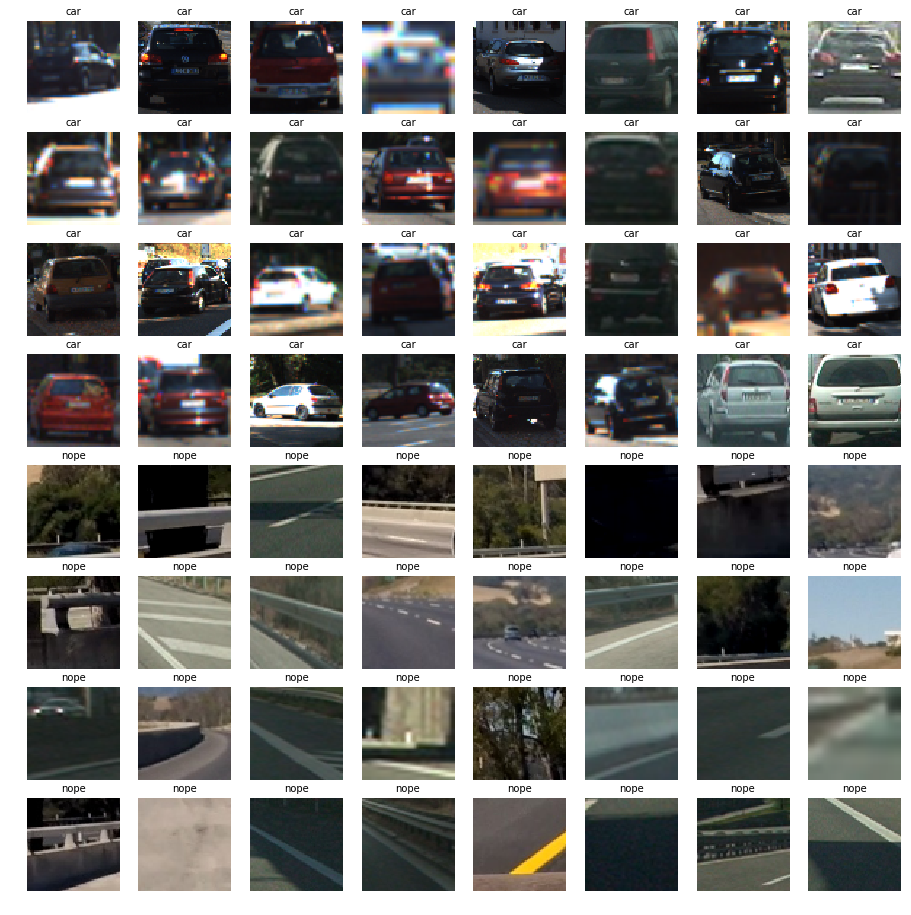

In [4]:
fig, axs = plt.subplots(8,8, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Step through the list and search for chessboard corners
for i in np.arange(32):
    img = cv2.imread(car_images[np.random.randint(0,len(car_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('car', fontsize=10)
    axs[i].imshow(img)
for i in np.arange(32,64):
    img = cv2.imread(noncar_images[np.random.randint(0,len(noncar_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('nope', fontsize=10)
    axs[i].imshow(img)

In [5]:
def getSampleHogImages(filenames, samples):
    images = []
    titels = []
    
    random_idxs = np.random.randint(0, len(filenames), samples)
    
    for i in random_idxs:
        vehicle_img = cv2.imread(filenames[i])
        vehicle_ycrcb = cv2.cvtColor(vehicle_img, cv2.COLOR_BGR2YCrCb)
        _, hog_img_0 = hog(vehicle_ycrcb[:,:,0], 9, (8, 8), (2, 2), visualise=True)
        _, hog_img_1 = hog(vehicle_ycrcb[:,:,1], 9, (8, 8), (2, 2), visualise=True)
        _, hog_img_2 = hog(vehicle_ycrcb[:,:,2], 9, (8, 8), (2, 2), visualise=True)
        titels.extend(['original', 'hog y-channel', 'hog cr-channel', 'hog cb-channel'])
        images.extend([cv2.cvtColor(vehicle_img, cv2.COLOR_BGR2RGB),  hog_img_0, hog_img_1, hog_img_2])
    
    return images, titels

C:\Users\shrey\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


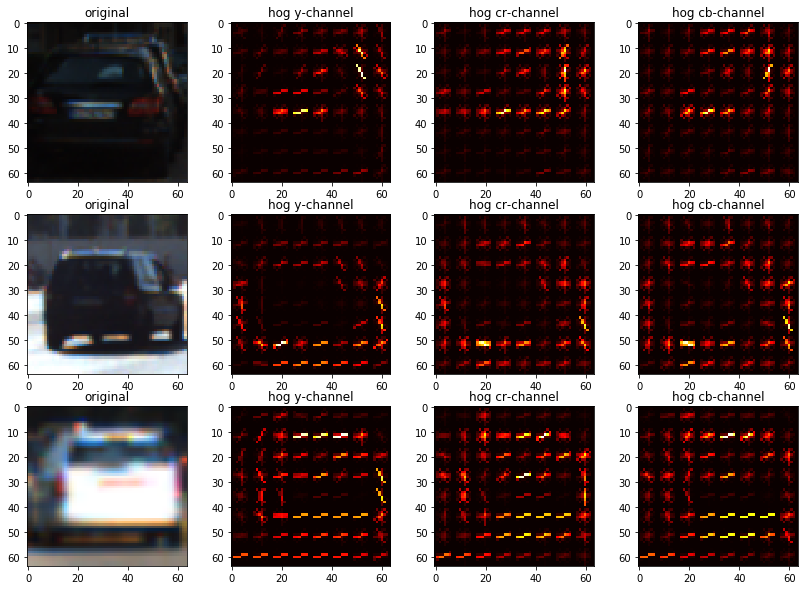

In [6]:
SAMPLES = 3
images, titels = getSampleHogImages(car_images, SAMPLES)
def plotImages(rows, cols, imgs, titles, cmap='hot', axis='on', figsize=(14, 10)):
    fig = plt.figure(figsize=figsize)
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i + 1)
        plt.title(titles[i])
        plt.axis(axis)
        if len(img.shape) < 3:
            plt.imshow(img, cmap=cmap)
        else:
            plt.imshow(img)
    plt.show()
plotImages(SAMPLES, 4, images, titels)

In [7]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [8]:
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:, :, 0], size).ravel()
    color2 = cv2.resize(img[:, :, 1], size).ravel()
    color3 = cv2.resize(img[:, :, 2], size).ravel()
    return np.hstack((color1, color2, color3))

In [9]:
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [10]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features

In [11]:
def extract_features(imgs, color_space='YCrCb', spatial_size=(32, 32), hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel='ALL', spatial_feat=True, hist_feat=True,
                     hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)
        if spatial_feat is True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat is True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat is True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                         orient, pix_per_cell, cell_per_block,
                                                         vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [12]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, hog_channel,
              spatial_size,
              hist_bins):
    draw_img = np.copy(img)
    img = img.astype(np.float32) / 255
    img_tosearch = img[ystart:ystop, :, :]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2' + color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))
    ch1 = ctrans_tosearch[:, :, 0]
    ch2 = ctrans_tosearch[:, :, 1]
    ch3 = ctrans_tosearch[:, :, 2]
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient * cell_per_block ** 2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    # Compute individual channel HOG features for the entire image
    if hog_channel == 'ALL':
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    else:
        hog1 = get_hog_features(hog_channel, orient, pix_per_cell, cell_per_block, feature_vec=False)
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            # Extract HOG for this patch
            if hog_channel == 'ALL':
                hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop + window, xleft:xleft + window], (64, 64))
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            test_prediction = svc.predict(test_features)
            if test_prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                cv2.rectangle(draw_img, (xbox_left, ytop_draw + ystart),
                              (xbox_left + win_draw, ytop_draw + win_draw + ystart), (0, 0, 255), 6)
    return draw_img

In [13]:
color_space='YCrCb'
spatial_size=(32, 32)
hist_bins=32
orient=9
pix_per_cell=8
cell_per_block=2
hog_channel='ALL'
spatial_feat=True
hist_feat=True
hog_feat=True

t=time.time()
car_features = extract_features(car_images, color_space=color_space, spatial_size=spatial_size,
                                hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block, hog_channel=hog_channel,
                                spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(noncar_images, color_space=color_space, spatial_size=spatial_size,
                                   hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,
                                   cell_per_block=cell_per_block, hog_channel=hog_channel,
                                   spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

C:\Users\shrey\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


113.63 Seconds to extract features...


In [14]:
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, stratify =y)
print('Feature vector length:', len(X_train[0]))

Feature vector length: 8460


In [16]:
svc = LinearSVC()
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

75.52 Seconds to train SVC...


In [17]:
svc.score(X_test, y_test)

0.99014639639639634

In [19]:
t=time.time()
n_predict = 20
print('SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

SVC predicts:  [ 0.  0.  0.  1.  0.  1.  1.  0.  1.  0.  1.  0.  0.  0.  0.  1.  0.  0.
  1.  1.]
For 20 labels:  [ 0.  0.  0.  1.  0.  1.  1.  0.  1.  0.  1.  0.  0.  0.  0.  1.  0.  0.
  1.  1.]
0.01563 Seconds to predict 20 labels with SVC


C:\Users\shrey\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


1


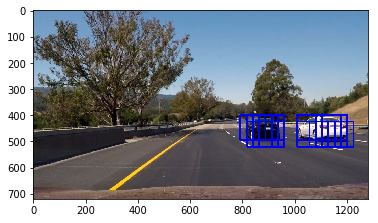

In [21]:
img = mpimg.imread('test_images/test6.jpg')
ystart = 400
ystop = 656
scale = 1.5
#t=time.time()
out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins)
plt.imshow(out_img)
#t2 = time.time()
#print(round(t2-t))

In [22]:
data={
    'svc': svc,
    'X_scaler': X_scaler,
    'color_space': color_space,
    'orient': orient,
    'pix_per_cell': pix_per_cell,
    'cell_per_block': cell_per_block,
    'spatial_size' : spatial_size,
    'hist_bins': hist_bins,
    'hog_channel': hog_channel
     }
with open('model-params.pk', 'wb') as pFile:
    pickle.dump(data, pFile)

C:\Users\shrey\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


([], <a list of 0 Text yticklabel objects>)

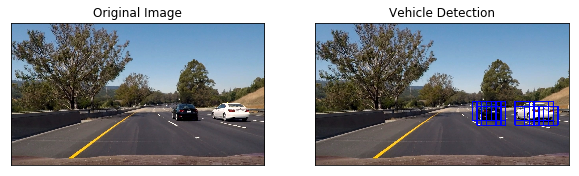

In [23]:
with open('model-params.pk', 'rb') as pfile:
    pickle_data = pickle.load(pfile)
    for key in pickle_data:
        exec(key + "= pickle_data['" + str(key) + "']")
    del pickle_data

img = mpimg.imread('test_images/test6.jpg')


ystart = 400
ystop = 656
scale = 1.5
   
out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins)

plt.figure(figsize=(10,40))
plt.subplot(121)
plt.imshow(img)
plt.title('Original Image')
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(out_img)
plt.title('Vehicle Detection')
plt.xticks([])
plt.yticks([])

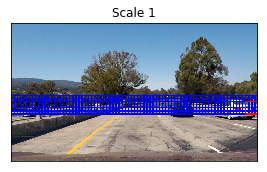

In [36]:
def draw_multi_scale_windows(img, ystart, ystop, scale):
    draw_img = np.copy(img)
    img = img.astype(np.float32) / 255

    img_tosearch = img[ystart:ystop, :, :]
    imshape = img_tosearch.shape
    img_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

    # Define blocks and steps as above
    nxblocks = (img_tosearch.shape[1] // pix_per_cell) - 1
    nyblocks = (img_tosearch.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient * cell_per_block ** 2

    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    rect_start = None
    rect_end = None
    for xb in range(nxsteps+1):
        for yb in range(nysteps+1):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            xbox_left = np.int(xleft * scale)
            ytop_draw = np.int(ytop * scale)
            win_draw = np.int(window * scale)
            rect_start = (xbox_left, ytop_draw + ystart)
            rect_end = (xbox_left + win_draw, ytop_draw + win_draw + ystart)
            cv2.rectangle(draw_img, rect_start, rect_end, (0, 0, 255), 6)
    
    cv2.rectangle(draw_img, rect_start, rect_end, (255, 0, 0), 6)

    return draw_img

img = mpimg.imread('test_images/test1.jpg')

plt.figure(figsize=(15,40))
subpltcount=1
for (ystart, ystop, scale) in [(380, 480, 1)]:
    plt.subplot(1,3,subpltcount)
    plt.imshow(draw_multi_scale_windows(img, ystart, ystop, scale))
    plt.title('Scale %s'%subpltcount)
    plt.xticks([])
    plt.yticks([])
    subpltcount +=1

In [30]:
class VehicleDetector:
    def __init__(self, model_param_files):
        # Loading Model Parameters
        with open(model_param_files, 'rb') as pfile:
            pickle_data = pickle.load(pfile)
            for key in pickle_data:
                exec("self." + key + "= pickle_data['" + str(key) + "']")
            del pickle_data
        # Current HeatMap
        self.heatmap = None
        # Heat Image for the Last Three Frames
        self.heat_images = deque(maxlen=3)
        # Current Frame Count
        self.frame_count = 0
        self.full_frame_processing_interval = 10
        # Xstart
        self.xstart = 600
        # Various Scales
        self.ystart_ystop_scale = [(360, 560, 1.5), (400, 600, 1.8), (440, 700, 2.5)]
        # Kernal For Dilation
        self.kernel = np.ones((50, 50))
        # Threshold for Heatmap
        self.threshold = 2
    def find_cars(self, img):
        X_scaler = self.X_scaler
        orient = self.orient
        pix_per_cell = self.pix_per_cell
        cell_per_block = self.cell_per_block
        spatial_size = self.spatial_size
        hist_bins = self.hist_bins
        svc = self.svc
        box_list = []
        draw_img = np.copy(img)
        img = img.astype(np.float32) / 255
        if self.frame_count % self.full_frame_processing_interval == 0:
            mask = np.ones_like(img[:, :, 0])
        else:
            mask = np.sum(np.array(self.heat_images), axis=0)
            mask[(mask > 0)] = 1
            mask = cv2.dilate(mask, self.kernel, iterations=1)
        self.frame_count += 1
        for (ystart, ystop, scale) in self.ystart_ystop_scale:
            nonzero = mask.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            if len(nonzeroy) != 0:
                ystart = max(np.min(nonzeroy), ystart)
                ystop = min(np.max(nonzeroy), ystop)
            if len(nonzeroy) != 0:
                xstart = max(np.min(nonzerox), self.xstart)
                xstop = np.max(nonzerox)
            else:
                continue
            if xstop <= xstart or ystop <= ystart:
                continue
            img_tosearch = img[ystart:ystop, xstart:xstop, :]
            ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
            if scale != 1:
                imshape = ctrans_tosearch.shape
                ys = np.int(imshape[1] / scale)
                xs = np.int(imshape[0] / scale)
                if (ys < 1 or xs < 1):
                    continue
                ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))
            if ctrans_tosearch.shape[0] < 64 or ctrans_tosearch.shape[1] < 64:
                continue
            ch1 = ctrans_tosearch[:, :, 0]
            ch2 = ctrans_tosearch[:, :, 1]
            ch3 = ctrans_tosearch[:, :, 2]
            # Define blocks and steps as above
            nxblocks = (ch1.shape[1] // pix_per_cell) - 1
            nyblocks = (ch1.shape[0] // pix_per_cell) - 1
            nfeat_per_block = orient * cell_per_block ** 2
            # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
            window = 64
            nblocks_per_window = (window // pix_per_cell) - 1
            cells_per_step = 2  # Instead of overlap, define how many cells to step
            nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
            nysteps = (nyblocks - nblocks_per_window) // cells_per_step
            # Compute individual channel HOG features for the entire image
            hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
            hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
            hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
            for xb in range(nxsteps + 1):
                for yb in range(nysteps + 1):
                    ypos = yb * cells_per_step
                    xpos = xb * cells_per_step
                    # Extract HOG for this patch
                    hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                    hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                    hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                    hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                    xleft = xpos * pix_per_cell
                    ytop = ypos * pix_per_cell
                    # Extract the image patch
                    subimg = ctrans_tosearch[ytop:ytop + window, xleft:xleft + window]
                    # Get color features
                    spatial_features = bin_spatial(subimg, size=spatial_size)
                    hist_features = color_hist(subimg, nbins=hist_bins)
                    # Scale features and make a prediction
                    test_features = X_scaler.transform(
                        np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
                    # test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))
                    test_prediction = svc.predict(test_features)
                    if test_prediction == 1:
                        xbox_left = xstart + np.int(xleft * scale)
                        ytop_draw = np.int(ytop * scale)
                        win_draw = np.int(window * scale)
                        box_list.append(
                            ((xbox_left, ytop_draw + ystart), (xbox_left + win_draw, ytop_draw + win_draw + ystart)))
        # Add heat to each box in box list
        self.add_heatmap_and_threshold(draw_img, box_list, self.threshold)
        # Find final boxes from heatmap using label function
        labels = label(self.heatmap)
        VehicleDetector.draw_labeled_bboxes(draw_img, labels)
        return draw_img
    def add_heatmap_and_threshold(self, draw_img, bbox_list, threshold):
        heatmap = np.zeros_like(draw_img[:, :, 0]).astype(np.float)
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        self.heat_images.append(heatmap)
        self.heatmap = np.sum(np.array(self.heat_images), axis=0)
        self.heatmap[self.heatmap <= threshold] = 0
    @staticmethod
    def draw_labeled_bboxes(img, labels):
        # Iterate through all detected cars
        for car_number in range(1, labels[1] + 1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)

C:\Users\shrey\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


([], <a list of 0 Text yticklabel objects>)

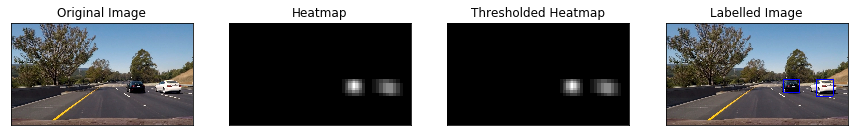

In [31]:
vehicleDetector = VehicleDetector('model-params.pk')
vehicleDetector.ystart_ystop_scale = [(380, 480, 1), (400, 600, 1.5), (500, 700, 2.5)]
vehicleDetector.threshold = 3
img = mpimg.imread('test_images/test6.jpg')
out = vehicleDetector.find_cars(img)
plt.figure(figsize=(15,40))
## Input Image
plt.subplot(141)
plt.imshow(img)
plt.title('Original Image')
plt.xticks([])
plt.yticks([])
## Heatmap
plt.subplot(142)
heatmap = vehicleDetector.heat_images[0]
plt.imshow(heatmap, cmap='gray')
plt.title('Heatmap')
plt.xticks([])
plt.yticks([])
## Thresholded Heatmap
plt.subplot(143)
t_heatmap = vehicleDetector.heatmap
plt.imshow(heatmap, cmap='gray')
plt.title('Thresholded Heatmap')
plt.xticks([])
plt.yticks([])
## Label Detection
plt.subplot(144)
from scipy.ndimage.measurements import label
labels = label(t_heatmap)
labelled_image = np.copy(img)
VehicleDetector.draw_labeled_bboxes(labelled_image, labels)
plt.imshow(labelled_image)
plt.title('Labelled Image')
plt.xticks([])
plt.yticks([])

In [32]:

from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'project_video_output_svc.mp4'
clip = VideoFileClip("project_video.mp4")#.subclip(t_start=30,t_end=35)
white_clip = clip.fl_image(vehicleDetector.find_cars)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output_svc.mp4
[MoviePy] Writing video project_video_output_svc.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [06:19<00:00,  2.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output_svc.mp4 

Wall time: 6min 21s
